In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy
import TouchDetection

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)
importlib.reload(TouchDetection)

from TradePosition import TradePosition
from TouchArea import TouchArea
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from TouchDetection import BacktestTouchDetectionParameters, calculate_touch_detection_area, plot_touch_detection_areas, np_mean, np_median

In [2]:
# symbol = "NVDA"
symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
# symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA" #
# symbol = "TJX" #


start_date = "2016-01-01 00:00:00"
end_date =   "2017-01-01 00:00:00"

# start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"

# Usage example:
touch_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='15:55',
    use_median=True,
    touch_area_width_agg=np_median,
    use_saved_bars=True,
    rolling_avg_decay_rate=0.85
    # export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

touch_detection_areas = calculate_touch_detection_area(touch_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='15:55', \
#     use_median=True, touch_area_width_agg=np_median, use_saved_bars=True, export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


In [3]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [4]:
zoom_start_date = start_date
zoom_end_date = end_date
# zoom_start_date = "2023-05-26 12:00:00"
# zoom_end_date = "2023-05-26 12:40:00"
plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [5]:
# len(touch_detection_areas['long_touch_area']) + len(touch_detection_areas['short_touch_area'])

In [6]:
params = StrategyParameters(
    initial_investment=10_000,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:50',
    
    # slippage_factor=0
)

# strategy = TradingStrategy(touch_detection_areas, params, export_trades_path='trades_output.csv')
# results = strategy.run_backtest()

In [9]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # generally high-liquidity from 2016 to present
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test3. generally high-liquidity from 2016 to 2019

In [10]:
trades_folder = 'test3/trades'
graphs_folder = 'test3/graphs'
xbp_folder = 'test3/xbp'

from IPython.utils import io
for s in symbols[10:]:
    touch_params.symbol = s
    touch_params.export_bars_path=f'bars/bars_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_params.symbol)
    # print(touch_params.export_bars_path)
    results_list = []
    
    # print(touch_params)
    touch_detection_areas = calculate_touch_detection_area(touch_params)
    # continue
    for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
        
        params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(touch_detection_areas, params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/graph_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_profit_loss_pct, win_mean_profit_loss_pct, lose_mean_profit_loss_pct, winrate, total_costs, \
                avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_profit_loss_pct,
            # 'winAvgPL%': win_mean_profit_loss_pct,
            # 'loseAvgPL%': lose_mean_profit_loss_pct,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg sub pos created': avg_sub_pos,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

Saved bars to bars/bars_META_2016-01-01_2017-01-01.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
META   2016-01-04 04:00:00-05:00  104.23  104.23  103.29  103.29  3866.0   
       2016-01-04 04:01:00-05:00  102.85  102.85  102.79  102.79   842.0   
       2016-01-04 04:02:00-05:00  102.85  102.85  102.79  102.79     0.0   
       2016-01-04 04:03:00-05:00  102.49  102.85  102.49  102.49  2264.0   
       2016-01-04 04:04:00-05:00  102.49  102.85  102.49  102.49     0.0   

                                  trade_count    vwap  
symbol timestamp                                       
META   2016-01-04 04:00:00-05:00         25.0  103.71  
       2016-01-04 04:01:00-05:00          7.0  102.80  
       2016-01-04 04:02:00-05:00          0.0     NaN  
       2016-01-04 04:03:00-05:00         11.0  102.52  
       2016-01-04 04:04:00-05:00          0.0     NaN  


100%|██████████| 8/8 [13:25<00:00, 100.70s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_26172\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_XOM_2016-01-01_2017-01-01.zip
                                   open   high   low  close  volume  \
symbol timestamp                                                      
XOM    2016-01-04 04:00:00-05:00  52.63  52.63  52.1   52.1  7550.0   
       2016-01-04 04:01:00-05:00  52.63  52.63  52.1   52.1     0.0   
       2016-01-04 04:02:00-05:00  52.63  52.63  52.1   52.1     0.0   
       2016-01-04 04:03:00-05:00  52.63  52.63  52.1   52.1     0.0   
       2016-01-04 04:04:00-05:00  52.63  52.63  52.1   52.1     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
XOM    2016-01-04 04:00:00-05:00         12.0  52.62  
       2016-01-04 04:01:00-05:00          0.0    NaN  
       2016-01-04 04:02:00-05:00          0.0    NaN  
       2016-01-04 04:03:00-05:00          0.0    NaN  
       2016-01-04 04:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [16:37<00:00, 124.64s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_26172\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_CVX_2016-01-01_2017-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
CVX    2016-01-04 04:00:00-05:00  62.19  62.19  62.19  62.19   100.0   
       2016-01-04 04:01:00-05:00  62.19  62.19  62.19  62.19     0.0   
       2016-01-04 04:02:00-05:00  62.19  62.19  62.19  62.19     0.0   
       2016-01-04 04:03:00-05:00  62.19  62.19  62.19  62.19     0.0   
       2016-01-04 04:04:00-05:00  62.19  62.19  62.19  62.19     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
CVX    2016-01-04 04:00:00-05:00          1.0  62.19  
       2016-01-04 04:01:00-05:00          0.0    NaN  
       2016-01-04 04:02:00-05:00          0.0    NaN  
       2016-01-04 04:03:00-05:00          0.0    NaN  
       2016-01-04 04:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [20:39<00:00, 154.98s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_26172\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_JNJ_2016-01-01_2017-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
JNJ    2016-01-04 07:12:00-05:00  80.25  80.25  80.25  80.25   200.0   
       2016-01-04 07:13:00-05:00  80.25  80.25  80.25  80.25     0.0   
       2016-01-04 07:14:00-05:00  80.25  80.25  80.25  80.25     0.0   
       2016-01-04 07:15:00-05:00  80.25  80.25  80.25  80.25     0.0   
       2016-01-04 07:16:00-05:00  80.25  80.25  80.25  80.25     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
JNJ    2016-01-04 07:12:00-05:00          2.0  80.25  
       2016-01-04 07:13:00-05:00          0.0    NaN  
       2016-01-04 07:14:00-05:00          0.0    NaN  
       2016-01-04 07:15:00-05:00          0.0    NaN  
       2016-01-04 07:16:00-05:00          0.0    NaN  


100%|██████████| 8/8 [19:51<00:00, 148.91s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_26172\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_PFE_2016-01-01_2017-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
PFE    2016-01-04 04:00:00-05:00  22.83  22.83  22.75  22.75   704.0   
       2016-01-04 04:01:00-05:00  22.83  22.83  22.75  22.75     0.0   
       2016-01-04 04:02:00-05:00  22.83  22.83  22.75  22.75     0.0   
       2016-01-04 04:03:00-05:00  22.83  22.83  22.75  22.75     0.0   
       2016-01-04 04:04:00-05:00  22.83  22.83  22.75  22.75     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
PFE    2016-01-04 04:00:00-05:00          4.0  22.76  
       2016-01-04 04:01:00-05:00          0.0    NaN  
       2016-01-04 04:02:00-05:00          0.0    NaN  
       2016-01-04 04:03:00-05:00          0.0    NaN  
       2016-01-04 04:04:00-05:00          0.0    NaN  


100%|██████████| 8/8 [10:30<00:00, 78.80s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_26172\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Saved bars to bars/bars_KO_2016-01-01_2017-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
KO     2016-01-04 04:06:00-05:00  32.41  32.41  32.41  32.41   200.0   
       2016-01-04 04:07:00-05:00  32.41  32.41  32.41  32.41     0.0   
       2016-01-04 04:08:00-05:00  32.41  32.41  32.41  32.41     0.0   
       2016-01-04 04:09:00-05:00  32.41  32.41  32.41  32.41     0.0   
       2016-01-04 04:10:00-05:00  32.41  32.41  32.41  32.41     0.0   

                                  trade_count   vwap  
symbol timestamp                                      
KO     2016-01-04 04:06:00-05:00          1.0  32.41  
       2016-01-04 04:07:00-05:00          0.0    NaN  
       2016-01-04 04:08:00-05:00          0.0    NaN  
       2016-01-04 04:09:00-05:00          0.0    NaN  
       2016-01-04 04:10:00-05:00          0.0    NaN  


100%|██████████| 8/8 [11:12<00:00, 84.06s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_26172\706542534.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


In [11]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [12]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

,symbol,xBP,net%,balance,cnt,WR%,TotalCosts,entryAdjust,entrySkip,exitAdjust,exitSkip,AllAvg,WinAvg,LoseAvg,LwinAvg,LwinMax,SwinAvg,SwinMax,LloseAvg,LloseMin,SloseAvg,SloseMin,WinMax,LoseMin
87,META,4.0,4013.2687,$411326.8725,9017,41.5438,$8320.0738,5589,2026,1072,21,0.2444,0.9411,-0.2508,0.9739,25.0971,0.9110,23.2375,-0.2506,-3.0401,-0.2510,-2.3756,25.0971,-2.3756
81,META,1.0,3012.4754,$311247.5413,9057,41.5701,$6917.3611,4968,1796,955,21,0.0639,0.2423,-0.0630,0.2498,10.0536,0.2354,8.1340,-0.0630,-0.7585,-0.0630,-0.5933,10.0536,-0.5933
7,AAPL,4.0,2848.2575,$294825.7496,5702,36.7766,$15431.4361,3545,1185,957,0,0.1967,0.9884,-0.2638,1.0252,15.5238,0.9512,14.1424,-0.2605,-1.3202,-0.2671,-1.4105,15.5238,-1.3202
39,AMZN,4.0,2647.4625,$274746.2537,5187,40.8329,$10297.1244,3196,1110,803,2383,0.2576,1.1919,-0.3872,1.2239,19.6116,1.1612,19.0839,-0.4308,-147.4968,-0.3454,-2.3007,19.6116,-2.3007
33,AMZN,1.0,1877.6300,$197763.0042,5234,40.7337,$8147.9150,2728,989,566,2410,0.0686,0.3098,-0.0972,0.3162,5.2639,0.3038,5.2524,-0.1077,-36.8742,-0.0873,-0.6276,5.2639,-0.6276
71,BAC,4.0,1822.8261,$192282.6069,4613,36.7873,$9095.5393,3058,1206,929,12,0.3424,1.6623,-0.4257,1.7420,29.2872,1.5899,30.5736,-0.4266,-2.7880,-0.4248,-2.6814,30.5736,-2.6814
65,BAC,1.0,1372.8747,$147287.4747,4642,36.7729,$7699.3608,2769,1124,738,12,0.0909,0.4311,-0.1070,0.4416,7.3139,0.4217,9.6158,-0.1066,-0.6959,-0.1073,-0.6694,9.6158,-0.6694
47,TSLA,4.0,1357.4516,$145745.1562,2784,40.7328,$4585.4164,1693,654,549,2963,0.4962,2.0945,-0.6023,2.1572,29.0195,2.0386,33.3701,-0.5983,-10.7921,-0.6057,-3.3313,33.3701,-3.3313
15,MSFT,4.0,1356.5379,$145653.7921,9132,37.6807,$5899.8258,5025,1859,1420,2,0.1803,0.8818,-0.2438,0.9082,14.2380,0.8545,26.1156,-0.2416,-2.0178,-0.2460,-2.6582,26.1156,-2.0178
1,AAPL,1.0,1346.3004,$144630.0433,5783,35.7081,$9506.8526,2426,1005,412,0,0.0525,0.2645,-0.0653,0.2789,5.5279,0.2499,3.5400,-0.0650,-0.3265,-0.0655,-0.3642,5.5279,-0.3265


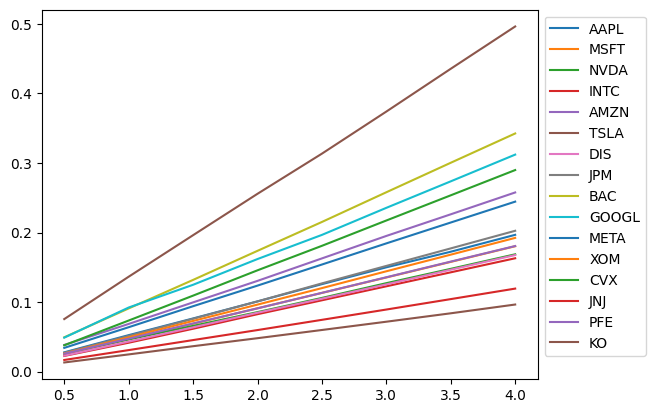

In [13]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

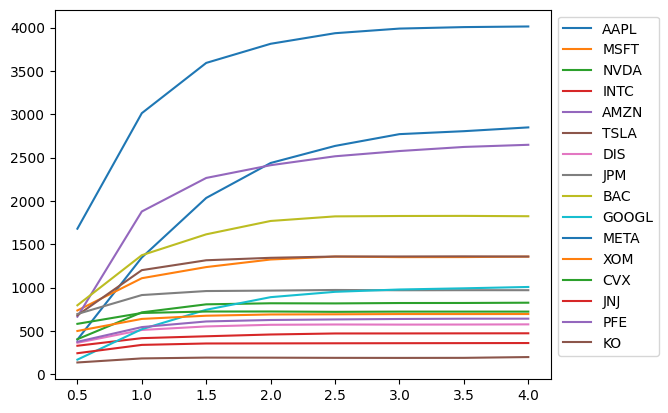

In [14]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

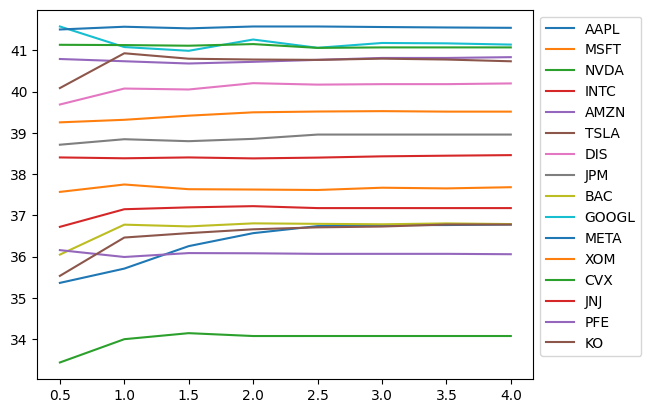

In [15]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()